# Schema Setup / Dataset Loading

In [2]:
from pyspark.sql.types import StructType, StructField, FloatType, LongType, StringType

feats = []
f = open('features.txt')
for line_num, line in enumerate(f):
    if line_num == 0:
        # Timestamp
        feats.append(StructField(line.strip(), LongType(), True))
    elif line_num == 1:
        # Geohash
        feats.append(StructField(line.strip(), StringType(), True))
    else:
        # Other features
        feats.append(StructField(line.strip(), FloatType(), True))
    
schema = StructType(feats)
print(schema)

df = spark.read.format('csv').option('sep', '\t').schema(schema).load('hdfs://orion12:50000/nam_tiny.tdv')

StructType(List(StructField(Timestamp,LongType,true),StructField(Geohash,StringType,true),StructField(geopotential_height_lltw,FloatType,true),StructField(water_equiv_of_accum_snow_depth_surface,FloatType,true),StructField(drag_coefficient_surface,FloatType,true),StructField(sensible_heat_net_flux_surface,FloatType,true),StructField(categorical_ice_pellets_yes1_no0_surface,FloatType,true),StructField(visibility_surface,FloatType,true),StructField(number_of_soil_layers_in_root_zone_surface,FloatType,true),StructField(categorical_freezing_rain_yes1_no0_surface,FloatType,true),StructField(pressure_reduced_to_msl_msl,FloatType,true),StructField(upward_short_wave_rad_flux_surface,FloatType,true),StructField(relative_humidity_zerodegc_isotherm,FloatType,true),StructField(categorical_snow_yes1_no0_surface,FloatType,true),StructField(u-component_of_wind_tropopause,FloatType,true),StructField(surface_wind_gust_surface,FloatType,true),StructField(total_cloud_cover_entire_atmosphere,FloatType,tru

# Preparing the Data

Spark ML models need two columns: features (predictors), and labels (the target feature being predicted). We need to adjust our dataframe accordingly.

In [3]:
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")


prepped = prepare_data(df,
    ["total_cloud_cover_entire_atmosphere", 
         "relative_humidity_zerodegc_isotherm", 
         "snow_cover_surface", 
         "visibility_surface"],
    "temperature_surface")

prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])


+--------------------+---------+
|            features|    label|
+--------------------+---------+
|[100.0,30.0,0.0,2...|296.49802|
|[30.0,81.0,0.0,24...|254.49802|
|[0.0,2.0,0.0,2422...|297.49802|
|[100.0,34.0,100.0...|272.74802|
|[78.0,2.0,0.0,242...|296.87302|
|[0.0,1.0,0.0,2422...|299.99802|
|[0.0,10.0,100.0,2...|270.37302|
|[0.0,38.0,0.0,242...|295.99802|
|[100.0,50.0,0.0,2...|292.49802|
|[100.0,95.0,0.0,1...|297.62302|
|[74.0,79.0,0.0,24...|288.37302|
|[100.0,77.0,100.0...|267.74802|
|[0.0,6.0,0.0,2422...|299.99802|
|[100.0,6.0,0.0,24...|285.62302|
|[100.0,36.0,0.0,2...|292.99802|
|[70.0,49.0,100.0,...|279.12302|
|[100.0,23.0,100.0...|273.12302|
|[0.0,24.0,0.0,242...|298.87302|
|[0.0,4.0,0.0,2422...|298.24802|
|[100.0,100.0,100....|276.99802|
+--------------------+---------+
only showing top 20 rows



In [4]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(numTrees=100, maxDepth=5, maxBins=32)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 7.65585


When I run this on the 'tiny'dataset, I get an RMSE of 6.9 degrees K. That's quite a bit of error, but let's see how well we're fitting our data visually...

# Lag Plot

Note: you may need to sample from the predictions if your dataset is too large.

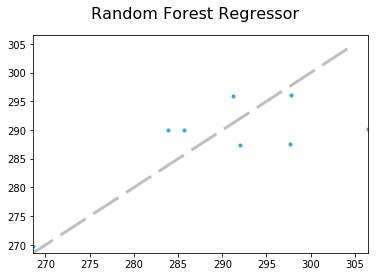

In [6]:
import matplotlib.pyplot as plt

p_df = predictions.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

Hmm, not so good... One big issue here is there is hardly any data available. Perhaps we need to compare with the full dataset, play with model parameters, or choose another model!

Side note: apart from some of the more obvious feature combinations, making weather predictions can be tricky. Don't get discouraged if you don't get incredible results.